## Summary

In this notebook we load a network trained to reconstruct protein sequences and use this network to design sequences that fit the geometry of CATH domain [1n5uA03](http://www.cathdb.info/version/latest/domain/1n5uA03).

----

## Imports

In [1]:
import os
from pathlib import Path

from IPython.display import HTML
from IPython.display import display

import matplotlib.pyplot as plt
import pandas as pd
import proteinsolver
import torch
import torch_geometric
from kmbio import PDB
from kmtools import sci_tools

/tmp/strokach/env/lib/python3.7/site-packages/Bio/KDTree/__init__.py:25: BiopythonDeprecationWarning: Bio.KDTree has been deprecated, and we intend to remove it in a future release of Biopython. Please use Bio.PDB.kdtrees instead, which is functionally very similar.
  BiopythonDeprecationWarning)


## Properties

In [2]:
NOTEBOOK_NAME = "protein_demo"

In [3]:
NOTEBOOK_PATH = Path(NOTEBOOK_NAME).resolve()
NOTEBOOK_PATH.mkdir(exist_ok=True)
NOTEBOOK_PATH

PosixPath('/home/kimlab1/strokach/workspace/proteinsolver/notebooks/protein_demo')

In [4]:
UNIQUE_ID = "191f05de"

In [5]:
BEST_STATE_FILES = {
    #
    "191f05de": 53
}

In [6]:
STRUCTURE_FILE = Path(os.getenv("STRUCTURE_FILE", NOTEBOOK_PATH / "inputs" / "1n5uA03.pdb")).resolve()
STRUCTURE_FILE

PosixPath('/home/kimlab1/strokach/workspace/proteinsolver/notebooks/protein_demo/inputs/1n5uA03.pdb')

In [7]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=1)

In [8]:
torch.cuda.is_available()

True

## Load structure

In [9]:
structure_all = PDB.load(STRUCTURE_FILE)
structure = PDB.Structure(STRUCTURE_FILE.name + "A", structure_all[0].extract('A'))
assert len(list(structure.chains)) == 1

In [10]:
PDB.view_structure(structure)

_ColormakerRegistry()

NGLWidget()

## Load model

In [11]:
%run protein_train/{UNIQUE_ID}/model.py

In [12]:
batch_size = 1
num_features = 20
adj_input_size = 2
hidden_size = 128
frac_present = 0.5
frac_present_valid = frac_present
info_size= 1024

In [13]:
state_files = sorted(
    Path("protein_train").joinpath(UNIQUE_ID).glob("*.state"),
    key=lambda s: int(s.stem.split("-")[2].strip("d")),
)

In [14]:
best_model_index = BEST_STATE_FILES[UNIQUE_ID]
best_model_index

53

In [15]:
state_file = state_files[best_model_index]
state_file

PosixPath('protein_train/191f05de/e53-s1952148-d93703104.state')

In [16]:
net = Net(
    x_input_size=num_features + 1, adj_input_size=adj_input_size, hidden_size=hidden_size, output_size=num_features
)
net.load_state_dict(torch.load(state_file, map_location=device))
net.eval()
net = net.to(device)

## Helper functions

In [17]:
import io
import logging
from typing import List
from unittest.mock import patch

import weblogo._cli
from PIL import Image

logger = logging.getLogger(__name__)


class _BytesIO(io.BytesIO):
    def __init__(self):
        super().__init__()
        self.buffer = self


def make_weblogo(
    seqs: List[str],
    units: str = "bits",
    color_scheme: str = "charge",
    stacks_per_line: int = 60,
    format_="png",
    output_file=None,
):
    assert format_ in ["eps", "png", "png_print", "pdf", "jpeg", "svg", "logodata"]

    weblogo_args = [
        "weblogo",
        f"--format={format_}",
        f"--units={units}",
        "--sequence-type=protein",
        f"--stacks-per-line={stacks_per_line}",
        f"--color-scheme={color_scheme}",
        "--scale-width=no",
        '--fineprint=""',
        "--composition=none",
    ]
    fin = io.StringIO()
    _write_sequences(seqs, fin)
    fin.seek(0)

    with patch("sys.stdin", fin), patch("weblogo._cli.sys.argv", weblogo_args), patch(
        "sys.stdout", new_callable=_BytesIO
    ) as patch_out:
        try:
            weblogo._cli.main()
        except RuntimeError as e:
            logger.error("Failed to create WebLogo image because of error: '%s'.", str(e))
            return None
        finally:
            patch_out.seek(0)
            img_data = patch_out.read()

    if output_file:
        with output_file.open("wb") as fout:
            fout.write(img_data)

    if format_ in ["eps", "png", "png_print", "jpeg"]:
        img = Image.open(io.BytesIO(img_data))
    else:
        img = None

    return img


def _write_sequences(seqs, fh):
    for i in range(len(seqs)):
        fh.write(f"> seq_{i}\n")
        fh.write(seqs[i] + "\n")

## Design pipeline

### Load protein sequence and geometry

In [18]:
pdata = proteinsolver.utils.extract_seq_and_adj(STRUCTURE_FILE, 'A')
print(pdata)
print(f"Protein sequence: '{pdata.sequence}'")
print(f"Number of amino acids: {len(pdata.sequence)}")

ProteinData(sequence='KFGERAFKAWAVARLSQRFPKAEFAEVSKLVTDLTKVHTECCHGDLLECADDRADLAKYICENQDSISSKLKECCEKPLLEKSHCIAEVEND', row_index=array([ 0,  0,  0, ..., 89, 89, 90]), col_index=array([ 1,  2,  3, ..., 90, 91, 91]), distances=array([1.32833195, 3.55097341, 7.17878066, ..., 1.32782137, 3.4453153 ,
       1.32591417]))
Protein sequence: 'KFGERAFKAWAVARLSQRFPKAEFAEVSKLVTDLTKVHTECCHGDLLECADDRADLAKYICENQDSISSKLKECCEKPLLEKSHCIAEVEND'
Number of amino acids: 92


### Convert data to suitable format

In [19]:
data = proteinsolver.datasets.protein.row_to_data(pdata)
data = proteinsolver.datasets.protein.transform_edge_attr(data)
data.to(device)

proteinsolver.utils.get_node_proba(net, data.x, data.edge_index, data.edge_attr).sum().item()

-170.00302124023438

### Run protein design using A* search

<span style="color: red">Feel free to interrupt at any time by pressing <code style="color: red">I, I</code> or going to <code style="color: red">Kernel -> Interrupt Kernel</code>.</span>

In [20]:
data = proteinsolver.datasets.protein.row_to_data(pdata)
data = proteinsolver.datasets.protein.transform_edge_attr(data)
data.to(device)

data.y = data.x
x_in = torch.ones_like(data.x) * 20
results = []
try:
    proteinsolver.utils.design_protein(net, x_in, data.edge_index, data.edge_attr, results=results, cutoff=np.log(0.15))
except KeyboardInterrupt:
    pass

i: 0; p: 0.0000; num missing: 92; heap size:       0; results size: 0


### Convert designs into a DataFrame

In [21]:
designs = [(r.x.data.cpu().numpy(), r.x_proba.data.cpu().numpy()) for r in results]

In [22]:
data = proteinsolver.datasets.protein.row_to_data(pdata)
# data = proteinsolver.datasets.protein.transform_edge_attr(data)

sequence_ref = "".join(proteinsolver.utils.AMINO_ACIDS[i] for i in data.x)

In [23]:
df = pd.DataFrame(designs, columns=["seq_array", "seq_proba_array"])

In [24]:
df["sequence"] = ["".join(proteinsolver.utils.AMINO_ACIDS[i] for i in seq_array) for seq_array in df["seq_array"]]

In [25]:
df["sum_log_prob"] = [seq_proba_array.sum() for seq_proba_array in df["seq_proba_array"]]

In [26]:
df["avg_log_prob"] = df["sum_log_prob"] / df["sequence"].str.len()

In [27]:
df["seq_identity"] = [
    float((seq_array == data.x.data.numpy()).sum().item()) / data.x.size(0)
    for seq_array in df["seq_array"]
]

In [28]:
df["index"] = df.index

In [29]:
df = df.sort_values("avg_log_prob", ascending=False).iloc[:200_000]

In [30]:
df.head(2)

,seq_array,seq_proba_array,sequence,sum_log_prob,avg_log_prob,seq_identity,index
0,"[6, 2, 0, 3, 10, 2, 7, 3, 2, 11, 2, 1, 2, 18, ...","[-1.9948293, -1.7749491, -0.18926732, -1.21726...",MAGLDAFLAEAVARLSARFPGASAAELARLTALETLTRLCCAAGDA...,-93.430267,-1.015546,0.413043,0
1,"[18, 2, 0, 3, 10, 2, 7, 3, 2, 11, 2, 1, 2, 18,...","[-2.043893, -1.7749491, -0.18926732, -1.217263...",RAGLDAFLAEAVARLSARFPGASAAELARLTALETLTRLCCAAGDA...,-93.479340,-1.016080,0.413043,1


In [31]:
columns_to_keep = ["index", "sequence", "sum_log_prob", "avg_log_prob", "seq_identity"]
df[columns_to_keep].to_csv(NOTEBOOK_PATH.joinpath(STRUCTURE_FILE.stem + ".csv"), sep="\t", index=False)

## Make plots

### Adjacency matrix

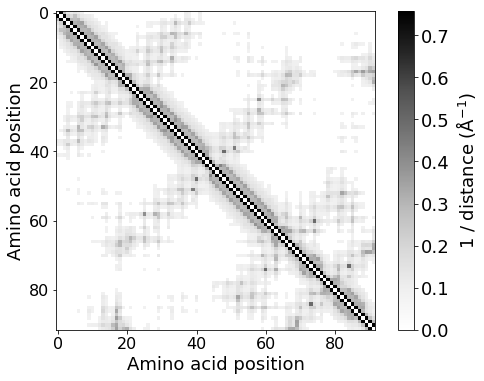

In [32]:
adj = torch_geometric.utils.to_dense_adj(edge_index=data.edge_index, edge_attr=1 / data.edge_attr[:, 0]).squeeze()

with plt.rc_context(rc={"font.size": 18}):
    fg, ax = plt.subplots(figsize=(8 * 0.9, 6 * 0.9))
    out = ax.imshow(adj, cmap="Greys")
    ax.set_ylabel("Amino acid position")
    ax.set_xlabel("Amino acid position")
    ax.tick_params("both", labelsize=16)
    cb = fg.colorbar(out, ax=ax)
    cb.set_label("1 / distance (Å$^{-1}$)")

fg.tight_layout()
fg.savefig(NOTEBOOK_PATH.joinpath(STRUCTURE_FILE.stem + "-adjacency.svg"))

### Score distributions

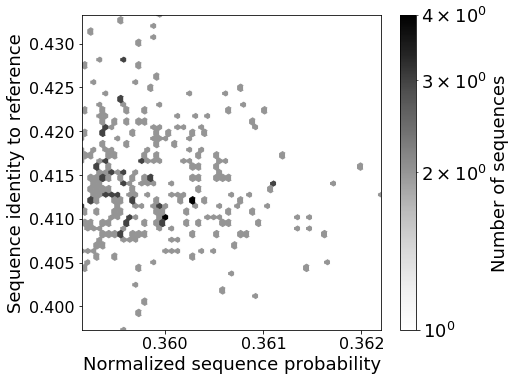

In [33]:
with plt.rc_context(rc={"font.size": 18}):
    fg, ax = plt.subplots(figsize=(8 * 0.9, 6 * 0.9))
    x = np.exp(df["avg_log_prob"])
    y = df["seq_identity"].values + 0.005 * np.random.randn(len(df))
    out = ax.hexbin(x, y, gridsize=50, bins="log", cmap="Greys")
    ax.set_xlim(x.min(), x.max())
    ax.set_ylim(y.min(), y.max())
    ax.set_ylabel("Sequence identity to reference")
    ax.set_xlabel("Normalized sequence probability")
    ax.tick_params("both", labelsize=16)
    cb = fg.colorbar(out, ax=ax)
    cb.set_label("Number of sequences")

fg.tight_layout()
fg.savefig(NOTEBOOK_PATH.joinpath(STRUCTURE_FILE.stem + "-hexbin.svg"))

### Sequence logo

In [34]:
make_weblogo(
    df["sequence"].values,
    units="probability",
    color_scheme="hydrophobicity",
    stacks_per_line=110,
    format_="svg",
    output_file=NOTEBOOK_PATH.joinpath(STRUCTURE_FILE.stem + "-weblogo-gen.svg"),
)

In [35]:
make_weblogo(
    [sequence_ref],
    units="probability",
    color_scheme="hydrophobicity",
    stacks_per_line=110,
    format_="svg",
    output_file=NOTEBOOK_PATH.joinpath(STRUCTURE_FILE.stem + "-weblogo-wt.svg"),
)

In [36]:
NOTEBOOK_PATH.joinpath(STRUCTURE_FILE.stem + "-weblogo-wt.svg")

PosixPath('/home/kimlab1/strokach/workspace/proteinsolver/notebooks/protein_demo/1n5uA03-weblogo-wt.svg')

In [37]:
display(HTML("""\
<div style="overflow: scroll; width: 100%">
<p style="text-align: center; margin-bottom: 0px"><b>Wild-type</b></p>
<img src="./protein_demo/1n5uA03-weblogo-wt.svg" style="width: 100%"/>

<p style="text-align: center; margin-bottom: 0px"><b>Designs</b></p>
<img src="./protein_demo/1n5uA03-weblogo-gen.svg" style="width: 100%"/>
</div>
"""))